# Lab 7: Sequential Networks


In this lab, you will select a prediction task to perform on your dataset, evaluate a sequential architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify.

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

Dataset Selection

Select a dataset that is text. That is, the dataset should be text data. In terms of generalization performance, it is helpful to have a medium sized dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification should be "many-to-one" sequence classification.

Dataset: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis



# 1.0 Data preparation

[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  

Now, we have our final dataset that is ready for the sentiment classification task. We have our "X" tensor containing all the 53818 tweets, vectorized into a sequence of integers using the Keras text Tokenizer. We leave the default options of the tokenizer restricted the length of the sequence to 1000 characters.. We also have our labels tensor as "y_ohe" in a one-hot encoded form.

In [22]:
import numpy as np
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import (GRU, LSTM, Activation, Conv1D, Dense,
                                     Dropout, Embedding, Flatten, Input,
                                     InputLayer, MaxPooling1D, concatenate)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset is a bit too large, so in the interest of saving time, we have reduced it by 50%, which still gets us 50000 samples.

In [68]:
# Upload the .csv file to /content/sample_data
df = pd.read_csv('/content/drive/MyDrive/lab7/Twitter_Data.csv')

df.dropna(inplace=True);
df = df.drop_duplicates()

# Specifying which datatypes you expect for each column
df['clean_text'] = df['clean_text'].astype(str)
df['category'] = df['category'].astype(int)
df.info()
df

df = df.sample(frac=0.5, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  object
 1   category    162969 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [69]:
# Binary classification - combining 1 and 0 into 1, and -1 into 0
print("Before replacing:")
print(df["category"].value_counts())
print('================================')
df = df[df['category'] != 0]
df['category'].replace(-1,0, inplace=True)
print("After replacing:")
print(df["category"].value_counts())

Before replacing:
category
 1    35979
 0    27666
-1    17839
Name: count, dtype: int64
After replacing:
category
1    35979
0    17839
Name: count, dtype: int64


<ipython-input-69-b607f9a6879b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'].replace(-1,0, inplace=True)


In [70]:
# making lists of the instances and targets ready to be tokenized
instances = df["clean_text"].to_list()
target = df["category"].to_numpy()

In [71]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 1000 # maximum and minimum number of words

# tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(instances)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(instances)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(target)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 60584 unique tokens. Distilled to 60584 top words.
Shape of data tensor: (53818, 1000)
Shape of label tensor: (53818, 2)
60584
CPU times: user 2.88 s, sys: 64 ms, total: 2.94 s
Wall time: 2.93 s


X_train Shape: (48436, 1000) Label Shape: (48436, 2)


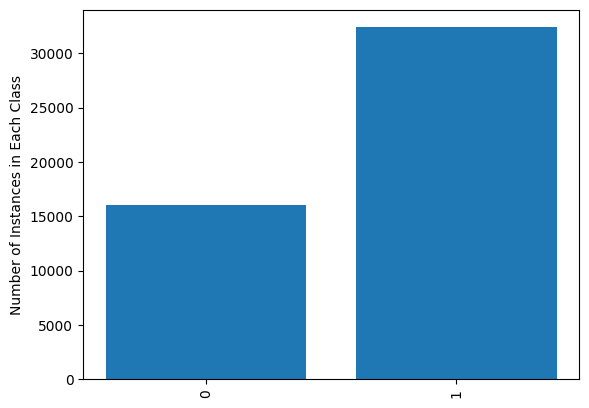

In [72]:
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.1,
                                                            stratify=target,
                                                            random_state=42)
NUM_CLASSES = 2

# print some stats of the data
print("X_train Shape:",X_train.shape, "Label Shape:", y_train_ohe.shape)
uniq_classes = np.sum(y_train_ohe,axis=0)
plt.bar(list(range(2)),uniq_classes)
plt.xticks(list(range(2)), rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

In [73]:
!ls -a "/content/sample_data/"

.   anscombe.json		 california_housing_train.csv  mnist_train_small.csv
..  california_housing_test.csv  mnist_test.csv		       README.md


In [74]:
!head "/content/drive/MyDrive/lab7/glove.6B.100d.txt"

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158 

In [75]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('/content/drive/MyDrive/lab7/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (60585, 100) 
 Total words found: 28935 
 Percentage: 47.75934637286457
CPU times: user 8.19 s, sys: 210 ms, total: 8.4 s
Wall time: 8.38 s


Adding embedding layer

In [76]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

# 1.1

[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

Because our classes are imbalanced - there are a lot more positivie tweets than negative tweets, using the F1 score would be better because it provides a balance between precision and recall and if there is an uneven class distribution, which there is.

[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.

We will be using stratified 10 fold Cross Valudation because it ensures that each fold reflects the overall distribution of the classes in the dataset, which prevents imbalance during training.

In [66]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train, y_train_ohe)
print(skf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


# 2.0 Modeling

[3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.

Model 1: CNN with 0.5 Dropout Rate

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_5 (Embedding)     (None, 1000, 100)         6058500   
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 128)          64128     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 199, 128)          0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 199, 128)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 195, 128)          82048     
                                                           

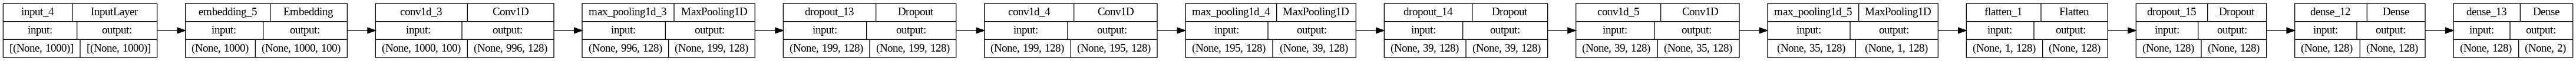

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, Input, Concatenate
from tensorflow.keras.layers import Subtract
from tensorflow.keras.utils import plot_model
import tensorflow as tf

EMBED_SIZE = 100  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.5)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.5)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(35)(x) # this is the size to globally flatten
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model = Model(sequence_input, preds)

print(model.summary())

# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Defining our custom f1 score function

In [35]:
import tensorflow as tf
from keras import backend as K
def f1_score(y_true, y_pred):
    # Calculate Precision and Recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate F1 score
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val



In [36]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True)
# clipnorm=1.0,

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[f1_score])

In [37]:
%%time

history = []
tmp = model.fit(X_train, y_train_ohe, epochs=60,
                batch_size=512,
                validation_data=(X_test, y_test_ohe))
history.append( tmp )

Epoch 1/60
95/95 [==============================] - 14s 91ms/step - loss: 0.6677 - f1_score: 0.6589 - val_loss: 0.6544 - val_f1_score: 0.6665
Epoch 2/60
95/95 [==============================] - 5s 54ms/step - loss: 0.6371 - f1_score: 0.6684 - val_loss: 0.6456 - val_f1_score: 0.6665
Epoch 3/60
95/95 [==============================] - 5s 55ms/step - loss: 0.6257 - f1_score: 0.6682 - val_loss: 0.6043 - val_f1_score: 0.6889
Epoch 4/60
95/95 [==============================] - 5s 54ms/step - loss: 0.5844 - f1_score: 0.6854 - val_loss: 0.5440 - val_f1_score: 0.7208
Epoch 5/60
95/95 [==============================] - 5s 54ms/step - loss: 0.5459 - f1_score: 0.7173 - val_loss: 0.5025 - val_f1_score: 0.7556
Epoch 6/60
95/95 [==============================] - 5s 54ms/step - loss: 0.5123 - f1_score: 0.7441 - val_loss: 0.4735 - val_f1_score: 0.7752
Epoch 7/60
95/95 [==============================] - 5s 54ms/step - loss: 0.4853 - f1_score: 0.7618 - val_loss: 0.4527 - val_f1_score: 0.7893
Epoch 8/60
9

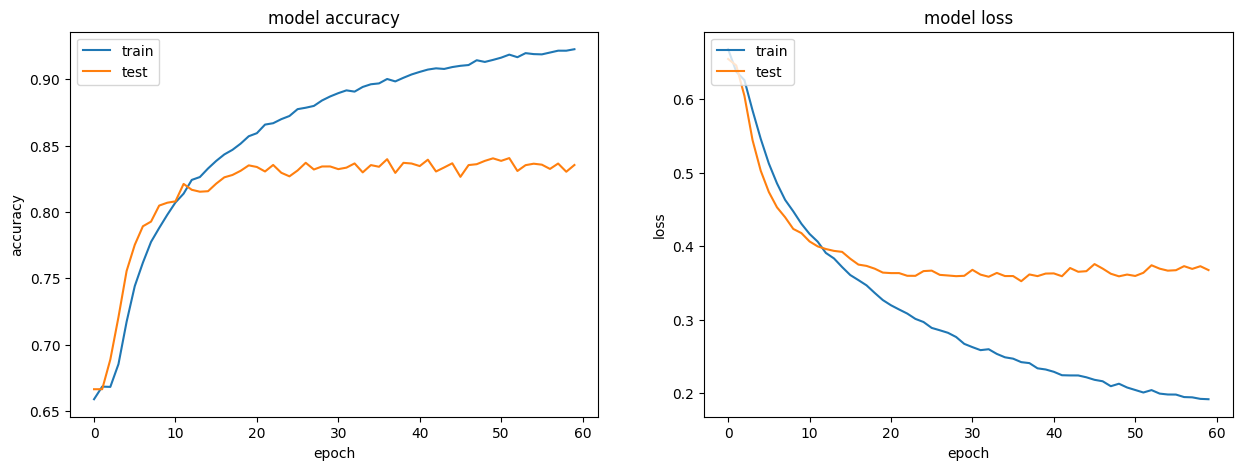

In [38]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['f1_score','val_f1_score','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['f1_score'])
plt.plot(combined['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model 2: CNN - Decreased Dropout Rate to 0.45

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_5 (Embedding)     (None, 1000, 100)         6058500   
                                                                 
 conv1d_6 (Conv1D)           (None, 996, 128)          64128     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 199, 128)          0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 199, 128)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 195, 128)          82048     
                                                           

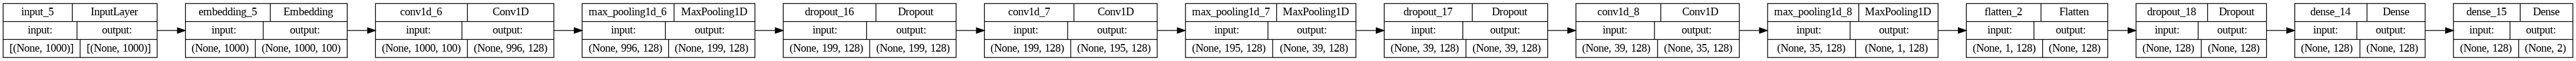

In [39]:
EMBED_SIZE = 100  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.45)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.45)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(35)(x) # this is the size to globally flatten
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.45)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model2 = Model(sequence_input, preds)

print(model2.summary())

# you will need to install pydot properly on your machine to get this running
plot_model(
    model2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [40]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True)
# clipnorm=1.0,

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
model2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[f1_score])

In [41]:
%%time

history2 = []
tmp2 = model2.fit(X_train, y_train_ohe, epochs=60,
                batch_size=512,
                validation_data=(X_test, y_test_ohe))
history2.append( tmp2 )

Epoch 1/60
95/95 [==============================] - 7s 57ms/step - loss: 0.6566 - f1_score: 0.6606 - val_loss: 0.6443 - val_f1_score: 0.6665
Epoch 2/60
95/95 [==============================] - 5s 54ms/step - loss: 0.6281 - f1_score: 0.6686 - val_loss: 0.6013 - val_f1_score: 0.6711
Epoch 3/60
95/95 [==============================] - 5s 54ms/step - loss: 0.5830 - f1_score: 0.6855 - val_loss: 0.5344 - val_f1_score: 0.7254
Epoch 4/60
95/95 [==============================] - 5s 55ms/step - loss: 0.5379 - f1_score: 0.7209 - val_loss: 0.4937 - val_f1_score: 0.7581
Epoch 5/60
95/95 [==============================] - 5s 55ms/step - loss: 0.5040 - f1_score: 0.7480 - val_loss: 0.4641 - val_f1_score: 0.7770
Epoch 6/60
95/95 [==============================] - 5s 54ms/step - loss: 0.4750 - f1_score: 0.7676 - val_loss: 0.4426 - val_f1_score: 0.7914
Epoch 7/60
95/95 [==============================] - 5s 54ms/step - loss: 0.4535 - f1_score: 0.7830 - val_loss: 0.4341 - val_f1_score: 0.7917
Epoch 8/60
95

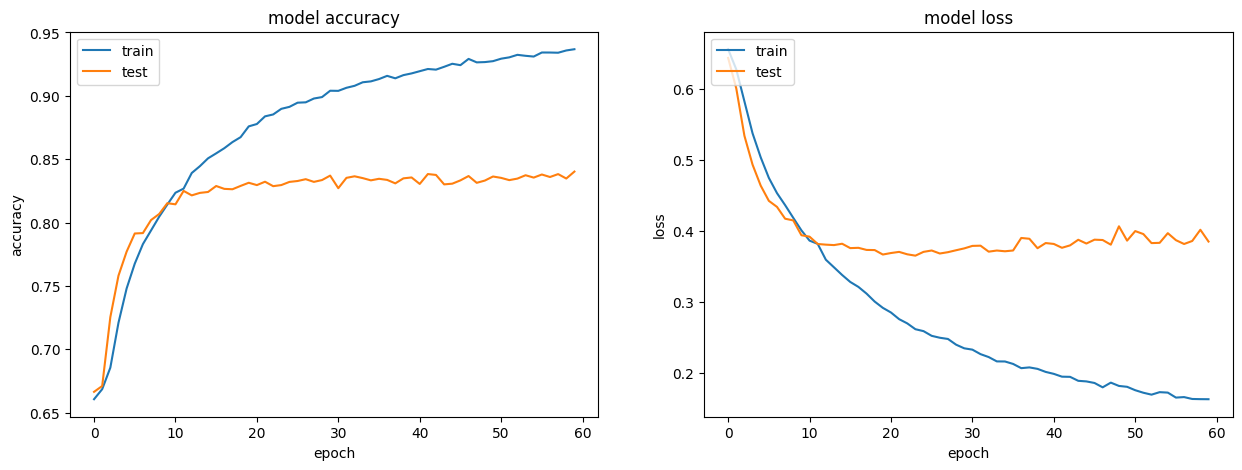

In [42]:
# combine all the history from training together
combined = dict()
for key in ['f1_score','val_f1_score','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history2])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['f1_score'])
plt.plot(combined['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model 3: Transformer Network with 0.5 Dropout Rate

In [43]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embed_dim)

        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)

        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key)
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)

        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)

        # apply dropout if training
        out1 = self.dropout1(out1, training=training)

        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)

        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size,
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen,
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [44]:
class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN,
                                 EMBED_SIZE,
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [45]:
EMBED_SIZE = 100
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer = Model(inputs=inputs, outputs=preds)
print(model_xformer.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1000)]            0         
                                                                 
 glove_token_and_position_e  (None, 1000, 100)         6158500   
 mbedding_2 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_3 (Trans  (None, 1000, 100)         87632     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_2  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_21 (Dropout)        (None, 100)               0   

In [46]:
model_xformer.compile(optimizer="adam",
                      loss='binary_crossentropy',
                      metrics=[f1_score])
history3 = []
tmp3 = model_xformer.fit(X_train, y_train_ohe, epochs=30,
                batch_size=512,
                validation_data=(X_test, y_test_ohe))
history3.append( tmp3 )

Epoch 1/30
95/95 [==============================] - 67s 676ms/step - loss: 0.6215 - f1_score: 0.6731 - val_loss: 0.5156 - val_f1_score: 0.7391
Epoch 2/30
95/95 [==============================] - 64s 672ms/step - loss: 0.4657 - f1_score: 0.7777 - val_loss: 0.4136 - val_f1_score: 0.8064
Epoch 3/30
95/95 [==============================] - 64s 672ms/step - loss: 0.4164 - f1_score: 0.8076 - val_loss: 0.3725 - val_f1_score: 0.8216
Epoch 4/30
95/95 [==============================] - 64s 672ms/step - loss: 0.3866 - f1_score: 0.8278 - val_loss: 0.3498 - val_f1_score: 0.8369
Epoch 5/30
95/95 [==============================] - 64s 672ms/step - loss: 0.3701 - f1_score: 0.8356 - val_loss: 0.3417 - val_f1_score: 0.8422
Epoch 6/30
95/95 [==============================] - 64s 673ms/step - loss: 0.3566 - f1_score: 0.8424 - val_loss: 0.3366 - val_f1_score: 0.8431
Epoch 7/30
95/95 [==============================] - 64s 673ms/step - loss: 0.3509 - f1_score: 0.8467 - val_loss: 0.3262 - val_f1_score: 0.8524

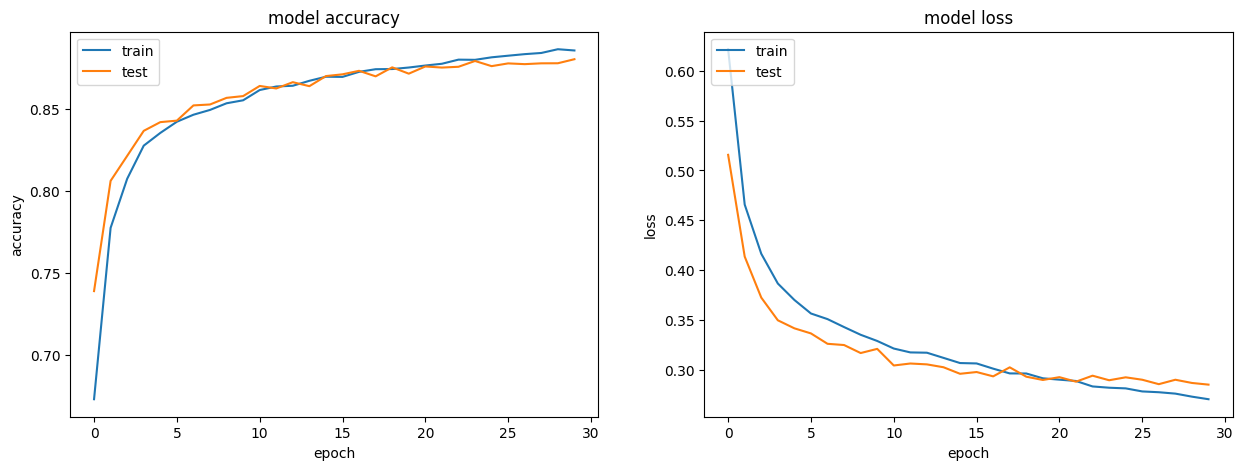

In [47]:
# combine all the history from training together
combined = dict()
for key in ['f1_score','val_f1_score','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history3])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['f1_score'])
plt.plot(combined['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model 4: Transformer - 0.45 Dropout Rate

In [50]:
EMBED_SIZE = 100
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.45)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.45)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer2 = Model(inputs=inputs, outputs=preds)
print(model_xformer2.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1000)]            0         
                                                                 
 glove_token_and_position_e  (None, 1000, 100)         6158500   
 mbedding_4 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_5 (Trans  (None, 1000, 100)         87632     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_4  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_29 (Dropout)        (None, 100)               0   

In [51]:
model_xformer2.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[f1_score])

history4 = []
tmp4 = model_xformer2.fit(X_train, y_train_ohe, epochs=30,
                batch_size=512,
                validation_data=(X_test, y_test_ohe))
history4.append( tmp4 )

Epoch 1/30
95/95 [==============================] - 67s 672ms/step - loss: 0.6218 - f1_score: 0.6730 - val_loss: 0.5207 - val_f1_score: 0.7449
Epoch 2/30
95/95 [==============================] - 64s 670ms/step - loss: 0.4684 - f1_score: 0.7745 - val_loss: 0.4012 - val_f1_score: 0.8052
Epoch 3/30
95/95 [==============================] - 64s 671ms/step - loss: 0.4163 - f1_score: 0.8050 - val_loss: 0.3792 - val_f1_score: 0.8133
Epoch 4/30
95/95 [==============================] - 64s 672ms/step - loss: 0.3952 - f1_score: 0.8185 - val_loss: 0.3572 - val_f1_score: 0.8351
Epoch 5/30
95/95 [==============================] - 64s 672ms/step - loss: 0.3716 - f1_score: 0.8331 - val_loss: 0.3511 - val_f1_score: 0.8442
Epoch 6/30
95/95 [==============================] - 64s 672ms/step - loss: 0.3632 - f1_score: 0.8388 - val_loss: 0.3413 - val_f1_score: 0.8455
Epoch 7/30
95/95 [==============================] - 64s 672ms/step - loss: 0.3524 - f1_score: 0.8447 - val_loss: 0.3305 - val_f1_score: 0.8506

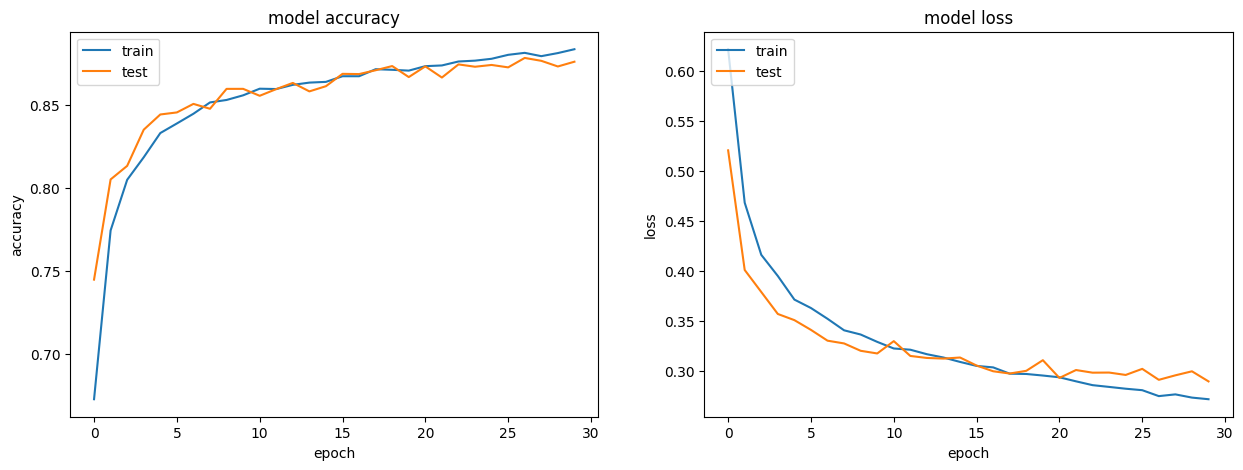

In [52]:
# combine all the history from training together
combined = dict()
for key in ['f1_score','val_f1_score','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history4])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['f1_score'])
plt.plot(combined['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 2.1

[1 points] Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer.  Visualize the performance of training and validation sets versus the training iterations, showing that the model converged..

Model 5 - Using our first Transformer network with dropout rate of 0.5

In [77]:
EMBED_SIZE = 100
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer3 = Model(inputs=inputs, outputs=preds)
print(model_xformer3.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1000)]            0         
                                                                 
 glove_token_and_position_e  (None, 1000, 100)         6158500   
 mbedding_7 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_10 (Tran  (None, 1000, 100)         47332     
 sformerBlock)                                                   
                                                                 
 transformer_block_11 (Tran  (None, 1000, 100)         47332     
 sformerBlock)                                                   
                                                                 
 global_average_pooling1d_7  (None, 100)               0  

In [78]:
model_xformer3.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[f1_score])


history5 = []
tmp5 = model_xformer3.fit(X_train, y_train_ohe, epochs=30,
                batch_size=512,
                validation_data=(X_test, y_test_ohe))
history5.append( tmp5 )

Epoch 1/30
95/95 [==============================] - 83s 820ms/step - loss: 0.6301 - f1_score: 0.6674 - val_loss: 0.5199 - val_f1_score: 0.7474
Epoch 2/30
95/95 [==============================] - 78s 816ms/step - loss: 0.4750 - f1_score: 0.7732 - val_loss: 0.4079 - val_f1_score: 0.8083
Epoch 3/30
95/95 [==============================] - 78s 817ms/step - loss: 0.4240 - f1_score: 0.8009 - val_loss: 0.3883 - val_f1_score: 0.8138
Epoch 4/30
95/95 [==============================] - 78s 817ms/step - loss: 0.4084 - f1_score: 0.8093 - val_loss: 0.3726 - val_f1_score: 0.8245
Epoch 5/30
95/95 [==============================] - 78s 818ms/step - loss: 0.4004 - f1_score: 0.8154 - val_loss: 0.3695 - val_f1_score: 0.8290
Epoch 6/30
95/95 [==============================] - 78s 817ms/step - loss: 0.3919 - f1_score: 0.8219 - val_loss: 0.3614 - val_f1_score: 0.8338
Epoch 7/30
95/95 [==============================] - 78s 817ms/step - loss: 0.3852 - f1_score: 0.8236 - val_loss: 0.3605 - val_f1_score: 0.8275

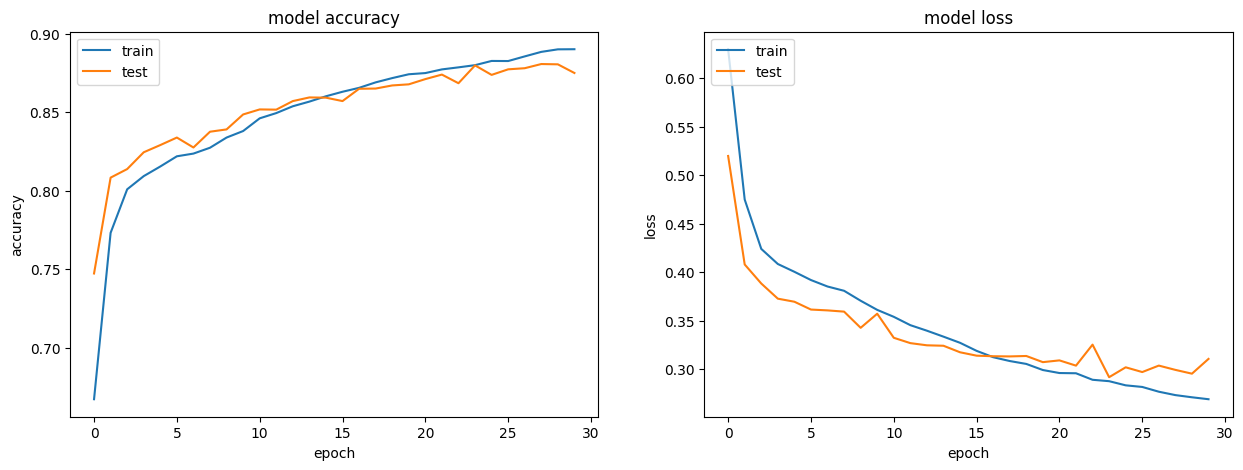

In [79]:
# combine all the history from training together
combined = dict()
for key in ['f1_score','val_f1_score','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history5])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['f1_score'])
plt.plot(combined['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 2.2

[2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

<ipython-input-106-83be566e7de2>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(model_names, rotation=45, ha='right')
<ipython-input-106-83be566e7de2>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(model_names, rotation=45, ha='right')
<ipython-input-106-83be566e7de2>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(model_names, rotation=45, ha='right')
<ipython-input-106-83be566e7de2>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(model_names, rotation=45, ha='right')


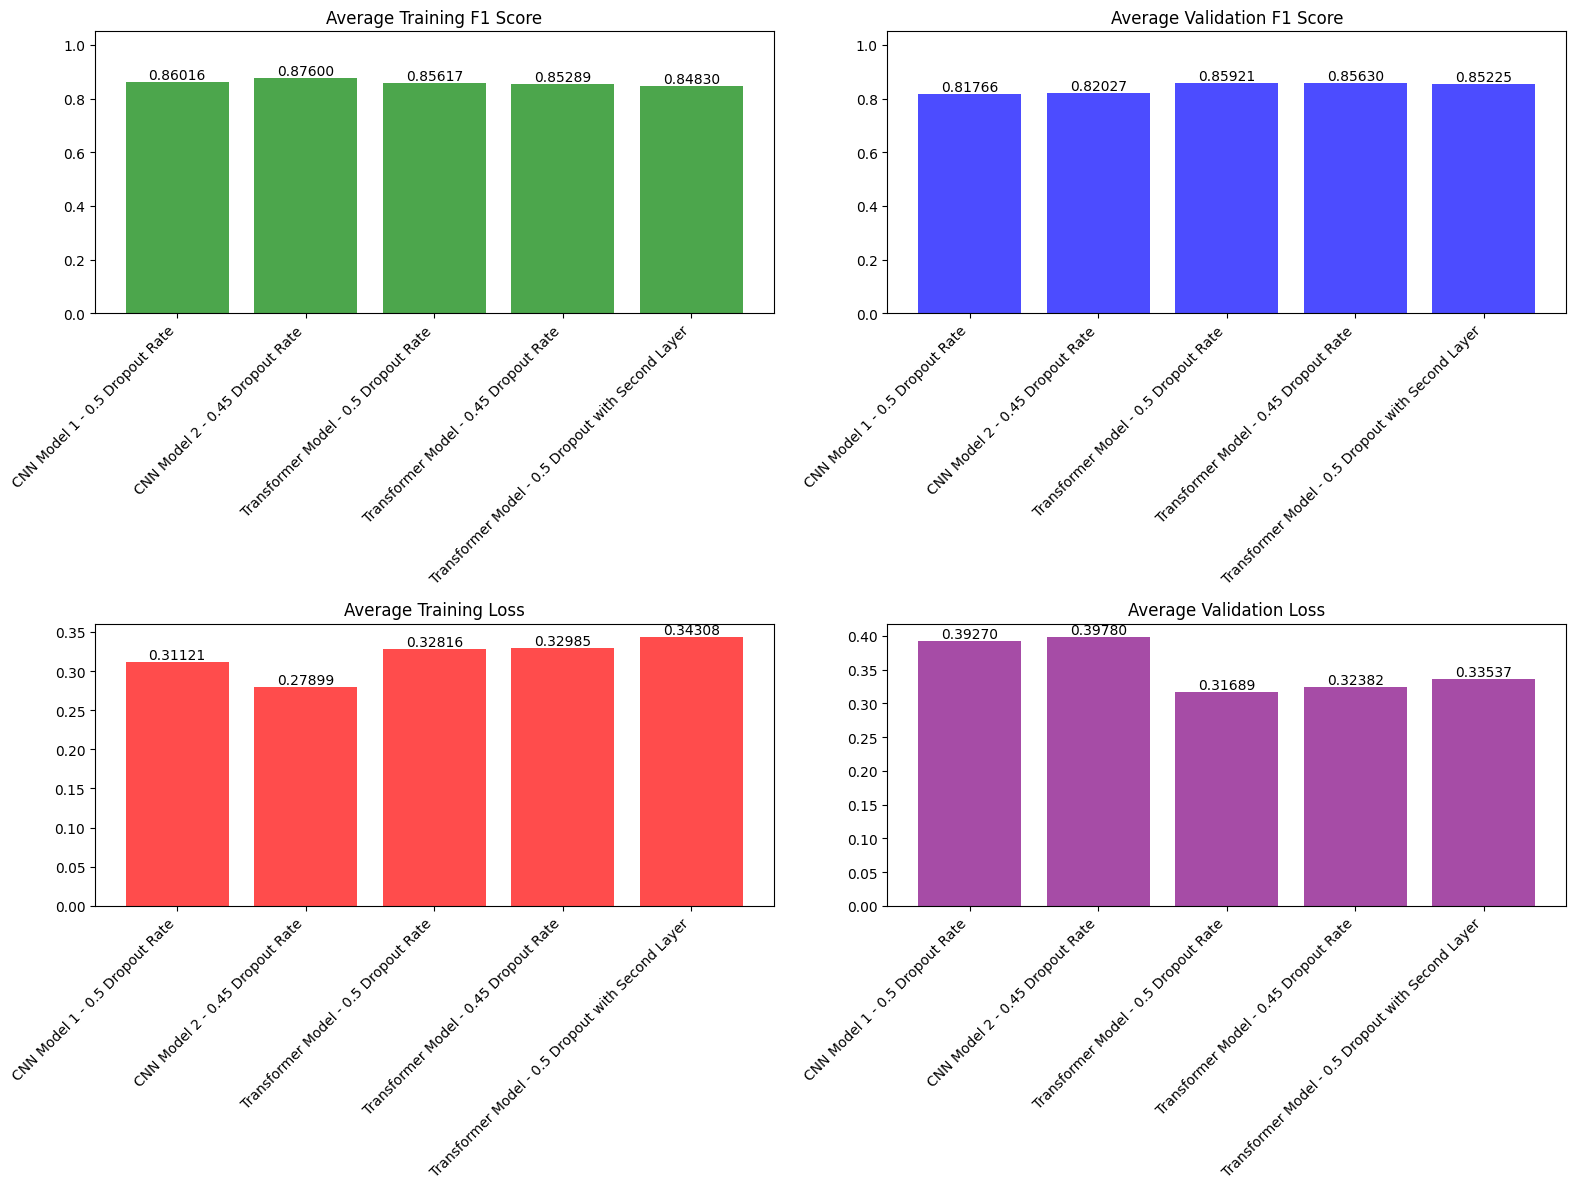

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Combine all the history from training together
combined = dict()
for key in ['f1_score', 'val_f1_score', 'loss', 'val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history])

combined2 = dict()
for key in ['f1_score', 'val_f1_score', 'loss', 'val_loss']:
    combined2[key] = np.hstack([x.history[key] for x in history2])

combined3 = dict()
for key in ['f1_score', 'val_f1_score', 'loss', 'val_loss']:
    combined3[key] = np.hstack([x.history[key] for x in history3])

combined4 = dict()
for key in ['f1_score', 'val_f1_score', 'loss', 'val_loss']:
    combined4[key] = np.hstack([x.history[key] for x in history4])

combined5 = dict()
for key in ['f1_score', 'val_f1_score', 'loss', 'val_loss']:
    combined5[key] = np.hstack([x.history[key] for x in history5])

# Calculate averages
average_val_f1 = [np.mean(combined['val_f1_score']), np.mean(combined2['val_f1_score']), np.mean(combined3['val_f1_score']), np.mean(combined4['val_f1_score']), np.mean(combined5['val_f1_score'])]
average_f1 = [np.mean(combined['f1_score']), np.mean(combined2['f1_score']), np.mean(combined3['f1_score']), np.mean(combined4['f1_score']), np.mean(combined5['f1_score'])]
average_val_loss = [np.mean(combined['val_loss']), np.mean(combined2['val_loss']), np.mean(combined3['val_loss']), np.mean(combined4['val_loss']), np.mean(combined5['val_loss'])]
average_loss = [np.mean(combined['loss']), np.mean(combined2['loss']), np.mean(combined3['loss']), np.mean(combined4['loss']), np.mean(combined5['loss'])]

model_names = ['CNN Model 1 - 0.5 Dropout Rate', 'CNN Model 2 - 0.45 Dropout Rate', 'Transformer Model - 0.5 Dropout Rate', 'Transformer Model - 0.45 Dropout Rate', 'Transformer Model - 0.5 Dropout with Second Layer']

# Setup the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid of subplots
axs = axs.ravel()  # Flatten the array of axes for easier access

# Function to add text labels above bars
def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')

# Bar chart for average training F1 scores
bars = axs[0].bar(model_names, average_f1, color='green', alpha=0.7)
axs[0].set_title('Average Training F1 Score')
axs[0].set_ylim([0, 1.05])
axs[0].set_xticklabels(model_names, rotation=45, ha='right')
add_labels(bars, axs[0])

# Bar chart for average validation F1 scores
bars = axs[1].bar(model_names, average_val_f1, color='blue', alpha=0.7)
axs[1].set_title('Average Validation F1 Score')
axs[1].set_ylim([0, 1.05])
axs[1].set_xticklabels(model_names, rotation=45, ha='right')
add_labels(bars, axs[1])

# Bar chart for average loss
bars = axs[2].bar(model_names, average_loss, color='red', alpha=0.7)
axs[2].set_title('Average Training Loss')
axs[2].set_xticklabels(model_names, rotation=45, ha='right')
add_labels(bars, axs[2])

# Bar chart for average validation loss
bars = axs[3].bar(model_names, average_val_loss, color='purple', alpha=0.7)
axs[3].set_title('Average Validation Loss')
axs[3].set_xticklabels(model_names, rotation=45, ha='right')
add_labels(bars, axs[3])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


From the graph above, we can see that our first Transformer Model is the most efficient with the highest validation f1_score of 0.85921. Meanwhile, our worst model was the first CNN Model, with a validation f1_score of 0.81766

# Exceptional Work

We will be trying one more CNN Model, this time with a dropout rate of 0.4, and comparing it to the other CNN models.

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1000)]            0         
                                                                 
 embedding_17 (Embedding)    (None, 1000, 100)         6058500   
                                                                 
 conv1d_9 (Conv1D)           (None, 996, 128)          64128     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 199, 128)          0         
 g1D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 199, 128)          0         
                                                                 
 conv1d_10 (Conv1D)          (None, 195, 128)          82048     
                                                          

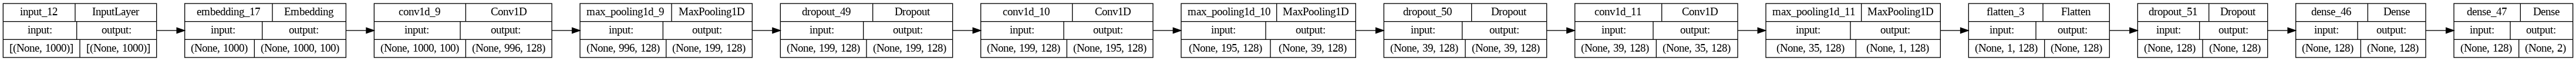

In [91]:
EMBED_SIZE = 100  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.4)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.4)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(35)(x) # this is the size to globally flatten
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model6 = Model(sequence_input, preds)

print(model6.summary())

# you will need to install pydot properly on your machine to get this running
plot_model(
    model6, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [92]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True)
# clipnorm=1.0,

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
model6.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[f1_score])

In [93]:
%%time

history6 = []
tmp6 = model6.fit(X_train, y_train_ohe, epochs=60,
                batch_size=512,
                validation_data=(X_test, y_test_ohe))
history6.append( tmp6 )

Epoch 1/60
95/95 [==============================] - 7s 57ms/step - loss: 0.6479 - f1_score: 0.6646 - val_loss: 0.6277 - val_f1_score: 0.6665
Epoch 2/60
95/95 [==============================] - 5s 54ms/step - loss: 0.6045 - f1_score: 0.6728 - val_loss: 0.5536 - val_f1_score: 0.7110
Epoch 3/60
95/95 [==============================] - 5s 55ms/step - loss: 0.5550 - f1_score: 0.7064 - val_loss: 0.5203 - val_f1_score: 0.7359
Epoch 4/60
95/95 [==============================] - 5s 55ms/step - loss: 0.5130 - f1_score: 0.7401 - val_loss: 0.4725 - val_f1_score: 0.7715
Epoch 5/60
95/95 [==============================] - 5s 55ms/step - loss: 0.4789 - f1_score: 0.7663 - val_loss: 0.4518 - val_f1_score: 0.7888
Epoch 6/60
95/95 [==============================] - 5s 55ms/step - loss: 0.4486 - f1_score: 0.7856 - val_loss: 0.4319 - val_f1_score: 0.7927
Epoch 7/60
95/95 [==============================] - 5s 54ms/step - loss: 0.4288 - f1_score: 0.7975 - val_loss: 0.4139 - val_f1_score: 0.8032
Epoch 8/60
95

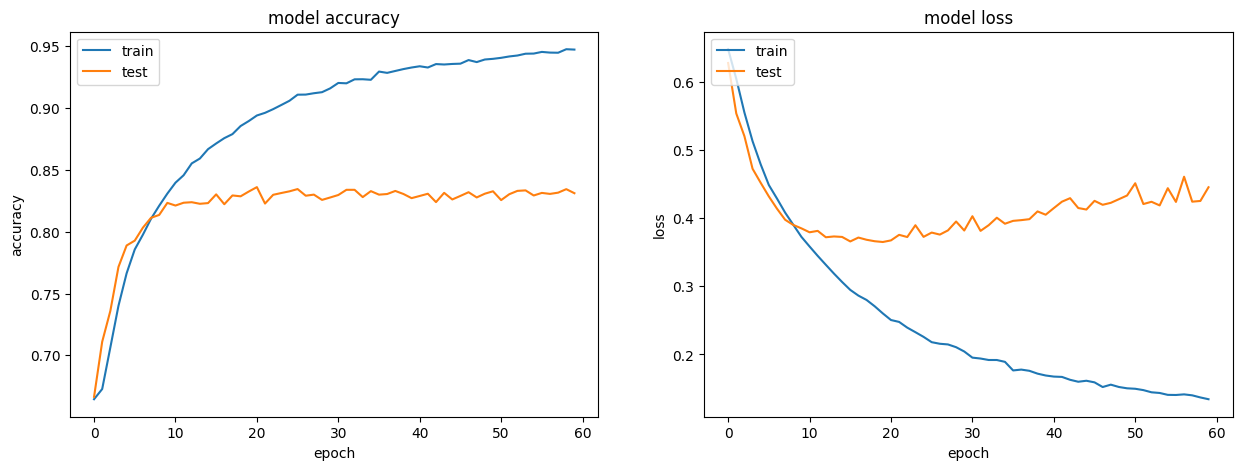

In [94]:
# combine all the history from training together
combined = dict()
for key in ['f1_score','val_f1_score','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history6])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['f1_score'])
plt.plot(combined['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<ipython-input-105-f7e0cb9b0279>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(model_names, rotation=45, ha='right')
<ipython-input-105-f7e0cb9b0279>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(model_names, rotation=45, ha='right')
<ipython-input-105-f7e0cb9b0279>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(model_names, rotation=45, ha='right')
<ipython-input-105-f7e0cb9b0279>:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(model_names, rotation=45, ha='right')


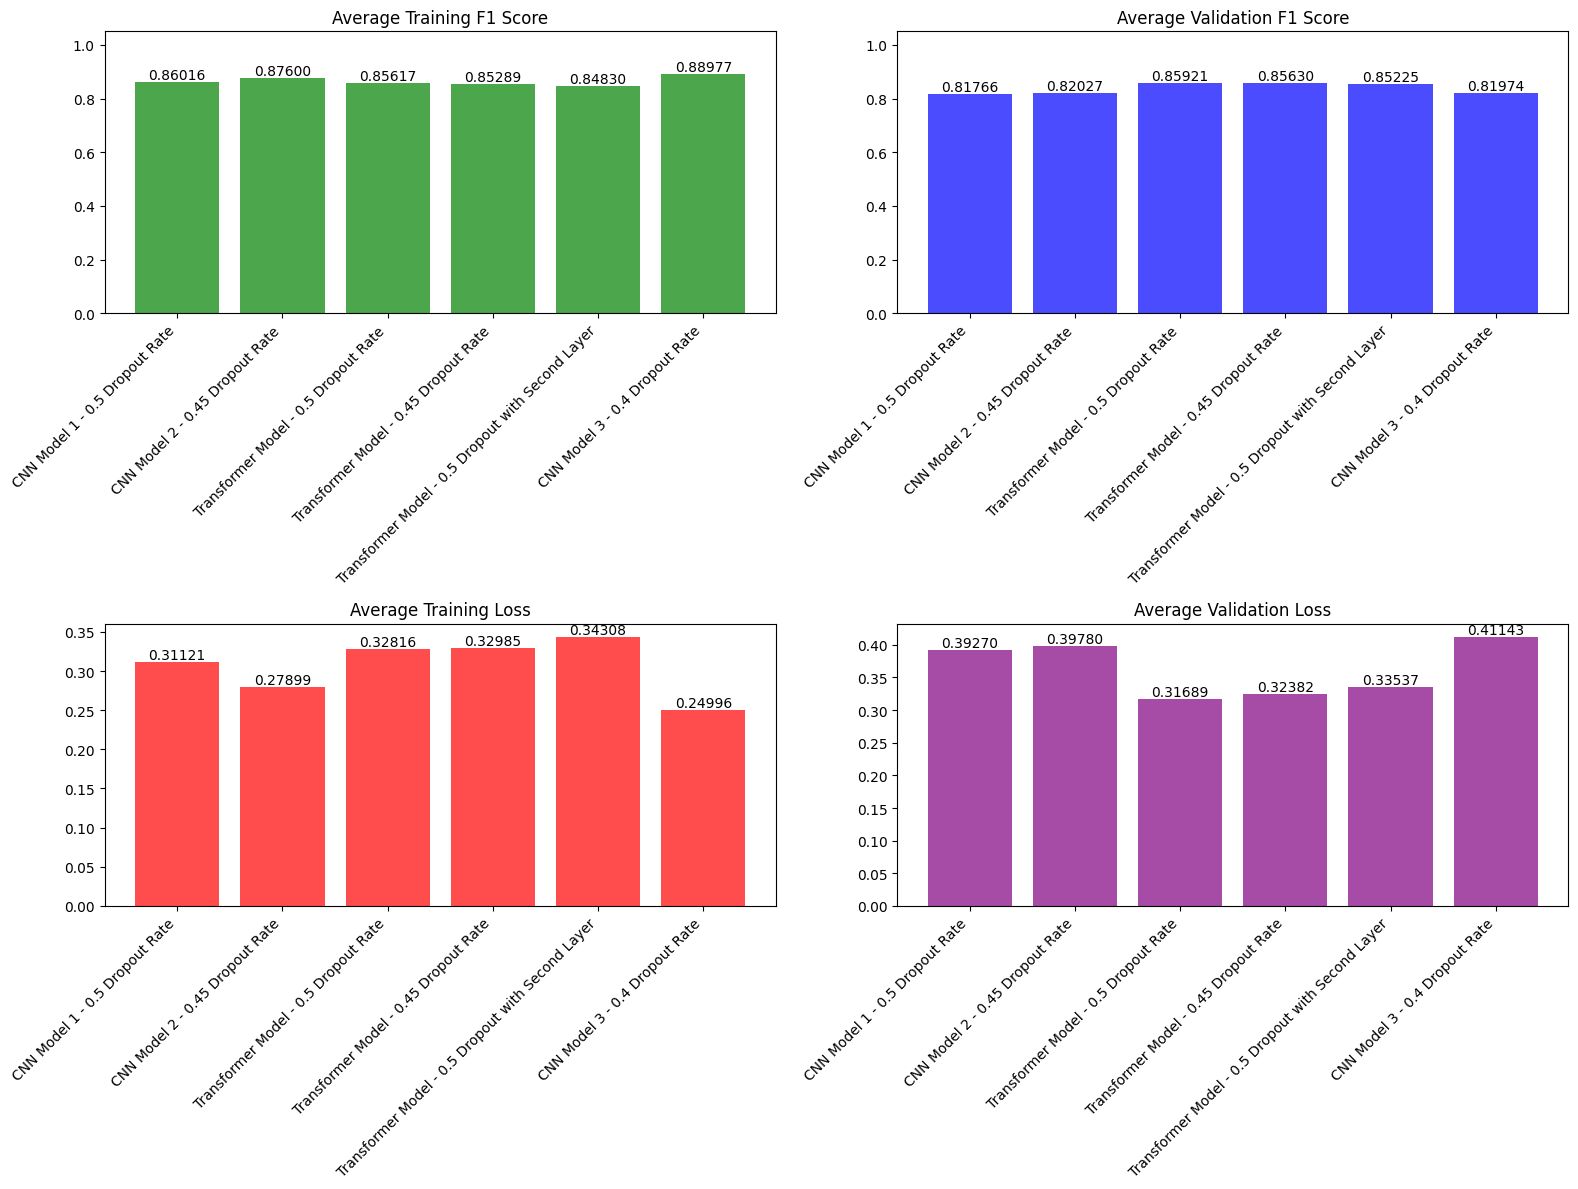

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Combine all the history from training together
combined = dict()
for key in ['f1_score', 'val_f1_score', 'loss', 'val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history])

combined2 = dict()
for key in ['f1_score', 'val_f1_score', 'loss', 'val_loss']:
    combined2[key] = np.hstack([x.history[key] for x in history2])

combined3 = dict()
for key in ['f1_score', 'val_f1_score', 'loss', 'val_loss']:
    combined3[key] = np.hstack([x.history[key] for x in history3])

combined4 = dict()
for key in ['f1_score', 'val_f1_score', 'loss', 'val_loss']:
    combined4[key] = np.hstack([x.history[key] for x in history4])

combined5 = dict()
for key in ['f1_score', 'val_f1_score', 'loss', 'val_loss']:
    combined5[key] = np.hstack([x.history[key] for x in history5])

combined6 = dict()
for key in ['f1_score', 'val_f1_score', 'loss', 'val_loss']:
    combined6[key] = np.hstack([x.history[key] for x in history6])

# Calculate averages
average_val_f1 = [np.mean(combined['val_f1_score']), np.mean(combined2['val_f1_score']), np.mean(combined3['val_f1_score']), np.mean(combined4['val_f1_score']), np.mean(combined5['val_f1_score']), np.mean(combined6['val_f1_score'])]
average_f1 = [np.mean(combined['f1_score']), np.mean(combined2['f1_score']), np.mean(combined3['f1_score']), np.mean(combined4['f1_score']), np.mean(combined5['f1_score']), np.mean(combined6['f1_score'])]
average_val_loss = [np.mean(combined['val_loss']), np.mean(combined2['val_loss']), np.mean(combined3['val_loss']), np.mean(combined4['val_loss']), np.mean(combined5['val_loss']), np.mean(combined6['val_loss'])]
average_loss = [np.mean(combined['loss']), np.mean(combined2['loss']), np.mean(combined3['loss']), np.mean(combined4['loss']), np.mean(combined5['loss']), np.mean(combined6['loss'])]

model_names = ['CNN Model 1 - 0.5 Dropout Rate', 'CNN Model 2 - 0.45 Dropout Rate', 'Transformer Model - 0.5 Dropout Rate', 'Transformer Model - 0.45 Dropout Rate', 'Transformer Model - 0.5 Dropout with Second Layer', 'CNN Model 3 - 0.4 Dropout Rate']

# Setup the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid of subplots
axs = axs.ravel()  # Flatten the array of axes for easier access

# Function to add text labels above bars
def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')

# Bar chart for average training F1 scores
bars = axs[0].bar(model_names, average_f1, color='green', alpha=0.7)
axs[0].set_title('Average Training F1 Score')
axs[0].set_ylim([0, 1.05])
axs[0].set_xticklabels(model_names, rotation=45, ha='right')
add_labels(bars, axs[0])

# Bar chart for average validation F1 scores
bars = axs[1].bar(model_names, average_val_f1, color='blue', alpha=0.7)
axs[1].set_title('Average Validation F1 Score')
axs[1].set_ylim([0, 1.05])
axs[1].set_xticklabels(model_names, rotation=45, ha='right')
add_labels(bars, axs[1])

# Bar chart for average loss
bars = axs[2].bar(model_names, average_loss, color='red', alpha=0.7)
axs[2].set_title('Average Training Loss')
axs[2].set_xticklabels(model_names, rotation=45, ha='right')
add_labels(bars, axs[2])

# Bar chart for average validation loss
bars = axs[3].bar(model_names, average_val_loss, color='purple', alpha=0.7)
axs[3].set_title('Average Validation Loss')
axs[3].set_xticklabels(model_names, rotation=45, ha='right')
add_labels(bars, axs[3])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


It's interesting to note that CNN Model 3 had the best training f1_score, but the second lowest validation f1_score. CNN Model 3 also had the lowest training loss, but the highest validation loss, indicating that some overfitting might be occuring.

In conclusion, the first Transformer Model is the best when it comes to validation f1_score, and validation loss, so out of our six models, our first Transformer Model is the best.

# References
1. https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb